#Credit Score Classification using Neural Network
- The dataset we use to day contain related data , the goal is to create a model to classify customer base on credit score to prevent manual effort

In [ ]:
# !pip install tensorflow==2.12.0

In [1]:
#Import Required Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats.contingency import chi2_contingency
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn.model_selection import train_test_split   # split dataset to train and test section
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, LabelEncoder # data preprocessing
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, precision_score, classification_report #evaluational module
from sklearn.pipeline import Pipeline  #Merging all process step(preprocessing, feature selection, trainning) in to a sequence
from sklearn.utils.class_weight import compute_class_weight # compute weight (w)

import tensorflow as tf
from keras import models
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from imblearn.over_sampling import SMOTE
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
import seaborn as sns

In [3]:
raw_train_df = pd.read_csv('train.csv')
raw_test_df = pd.read_csv('test.csv')

train_df = raw_train_df.copy()
test_df = raw_test_df.copy()

In [4]:
train_df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30395 entries, 0 to 30394
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        30395 non-null  object 
 1   Customer_ID               30395 non-null  object 
 2   Month                     30395 non-null  object 
 3   Name                      27350 non-null  object 
 4   Age                       30395 non-null  object 
 5   SSN                       30395 non-null  object 
 6   Occupation                30395 non-null  object 
 7   Annual_Income             30395 non-null  object 
 8   Monthly_Inhand_Salary     25845 non-null  float64
 9   Num_Bank_Accounts         30395 non-null  int64  
 10  Num_Credit_Card           30395 non-null  int64  
 11  Interest_Rate             30395 non-null  int64  
 12  Num_of_Loan               30395 non-null  object 
 13  Type_of_Loan              26931 non-null  object 
 14  Delay_

In [6]:
test_df.describe()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,34766.000000,40903.000000,40903.000000,40903.000000,40903.000000,40070.000000,40903.000000,40902.000000
mean,4178.239911,17.109796,22.759382,70.056940,21.100995,30.383803,32.282031,1498.336092
std,3180.321566,117.532433,129.060125,458.842814,14.870489,198.455105,5.095790,8608.948306
min,319.556250,-1.000000,0.000000,1.000000,-5.000000,0.000000,20.509652,0.000000
25%,1623.130833,3.000000,4.000000,8.000000,10.000000,4.000000,28.086183,32.589795
50%,3062.688750,6.000000,6.000000,14.000000,18.000000,7.000000,32.263469,74.693874
75%,5929.296667,7.000000,7.000000,20.000000,28.000000,10.000000,36.464784,175.009626
max,15204.633333,1798.000000,1499.000000,5799.000000,67.000000,2593.000000,48.540663,82398.000000


In [7]:
train_df.shape

(30395, 28)

In [8]:
test_df.shape

(40903, 27)

If you want to have full view about two dataframe, use concat

In [9]:
df = pd.concat([train_df, test_df])

In [10]:
df.shape

(71298, 28)

Save full df to csv file

In [11]:
df.to_csv('full.csv', index=False)

In [12]:
df.isnull().sum()

,0
ID,0
Customer_ID,0
Month,0
Name,7163
Age,0
SSN,0
Occupation,0
Annual_Income,0
Monthly_Inhand_Salary,10687
Num_Bank_Accounts,0


There are some missing values, we need to handle it to prevent bad effot to our model

##Feature selection

In [13]:
df = df[df['Payment_Behaviour'] != '!@9#%8']
df[['Spending_Level', 'Payment_Value']] = df['Payment_Behaviour'].str.split('_', n=1, expand=True) #Split the column to 2 columns to increase feature
df['Payment_Value'] = df['Payment_Value'].str.rsplit('_', n=1, expand=True)[0]  # eg. Small_value_payment --> Small
df['Payment_Value'] = df['Payment_Value'].str.rsplit('_', n=1, expand=True)[0]  # ---------------------------------
df['Payment_Value'] = df['Payment_Value'].str.replace('spent_', '') # eg.High_spent ---> High

In [14]:
#Spliting with train_df
train_df = train_df[train_df['Payment_Behaviour'] != '!@9#%8']
train_df[['Spending_Level', 'Payment_Value']] = train_df['Payment_Behaviour'].str.split('_', n=1, expand=True) #Split the column to 2 columns to increase feature
train_df['Payment_Value'] = train_df['Payment_Value'].str.rsplit('_', n=1, expand=True)[0]  # eg. Small_value_payment --> Small
train_df['Payment_Value'] = train_df['Payment_Value'].str.rsplit('_', n=1, expand=True)[0]  # ---------------------------------
train_df['Payment_Value'] = train_df['Payment_Value'].str.replace('spent_', '') # eg.High_spent ---> High


In [15]:
# Cleaning and Feature Engineering for test_df
test_df = test_df[test_df['Payment_Behaviour'] != '!@9#%8']
test_df[['Spending_Level', 'Payment_Value']] = test_df['Payment_Behaviour'].str.split('_', n=1, expand=True)
test_df['Payment_Value'] = test_df['Payment_Value'].str.rsplit('_', n=1, expand=True)[0]
test_df['Payment_Value'] = test_df['Payment_Value'].str.rsplit('_', n=1, expand=True)[0]
test_df['Payment_Value'] = test_df['Payment_Value'].str.replace('spent_', '')

In [16]:
df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Spending_Level,Payment_Value
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good,High,Small
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good,Low,Large
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good,Low,Medium
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good,Low,Small
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good,High,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40898,0x1f54c,CUS_0x8a36,November,NaN,38,509-64-1439,Entrepreneur,34102.64,2742.886667,7,...,23.807748,NaN,Yes,140.119803,NaN,Low_spent_Small_value_payments,165.20088172113688,NaN,Low,Small
40899,0x1f54d,CUS_0x8a36,December,Kristeny,38,509-64-1439,Entrepreneur,34102.64,2742.886667,7,...,38.875719,10 Years and 4 Months,NM,140.119803,76.54325765715589,Low_spent_Medium_value_payments,337.62560602920325,NaN,Low,Medium
40900,0x1f556,CUS_0x54b,September,Evaa,31,468-64-0497,Architect,55209.81,4303.817500,5,...,33.499413,NaN,NM,231.927811,159.0413097687305,High_spent_Small_value_payments,299.4126290130695,NaN,High,Small
40901,0x1f557,CUS_0x54b,October,Evaa,31,#F%$D@*&8,Architect,55209.81,4303.817500,5,...,23.926878,14 Years and 8 Months,Yes,231.927811,85.71225287591633,High_spent_Medium_value_payments,362.7416859058836,NaN,High,Medium


In [17]:
train_df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Spending_Level,Payment_Value
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good,High,Small
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good,Low,Large
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good,Low,Medium
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good,Low,Small
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good,High,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30390,0xc810,CUS_0x90cf,July,McCoolw,53_,058-50-1241,Media_Manager,106234.11000000002,8699.842500,4,...,23.595624,27 Years and 3 Months,No,201.113490,325.6671223639741,High_spent_Medium_value_payments,593.2036374964807,Standard,High,Medium
30391,0xc811,CUS_0x90cf,August,McCoolw,53,058-50-1241,Media_Manager,106234.11000000002,8699.842500,4,...,36.009422,NaN,No,201.113490,625.8471560943485,Low_spent_Large_value_payments,313.02360376610636,Standard,Low,Large
30392,0xc816,CUS_0x686c,January,NaN,36,666-90-8248,Developer,10143.89,684.324167,4,...,23.002059,19 Years and 10 Months,Yes,22.886533,50.41183191530408,Low_spent_Small_value_payments,285.134051935071,Standard,Low,Small
30393,0xc817,CUS_0x686c,February,Kiharap,36,666-90-8248,Developer,10143.89,684.324167,4,...,25.142233,NaN,Yes,22.886533,46.36582910605607,Low_spent_Small_value_payments,289.180054744319,Standard,Low,Small


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65945 entries, 0 to 40902
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        65945 non-null  object 
 1   Customer_ID               65945 non-null  object 
 2   Month                     65945 non-null  object 
 3   Name                      59302 non-null  object 
 4   Age                       65945 non-null  object 
 5   SSN                       65945 non-null  object 
 6   Occupation                65945 non-null  object 
 7   Annual_Income             65945 non-null  object 
 8   Monthly_Inhand_Salary     56046 non-null  float64
 9   Num_Bank_Accounts         65945 non-null  int64  
 10  Num_Credit_Card           65945 non-null  int64  
 11  Interest_Rate             65945 non-null  int64  
 12  Num_of_Loan               65945 non-null  object 
 13  Type_of_Loan              58478 non-null  object 
 14  Delay_from_

We can see that now from ***'Payment_Behaviour'***  column, now we have two new columns is ***'Spending_Level',	'Payment_Value'***

Beacause "Age" column's dtype is object, so we need to turn it into numeric dtype

In [19]:
# drop_columns = ['ID', 'Customer_ID', 'Name', 'SSN', 'Month','Type_of_Loan', 'Payment_Behaviour']
# df.drop(drop_columns, axis=1, inplace=True)

In [20]:
df.shape

(65945, 30)

In [21]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Spending_Level,Payment_Value
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good,High,Small
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good,Low,Large
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good,Low,Medium
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good,Low,Small
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good,High,Medium


##Split df into Categorical column and  numerical column

In [22]:
num_cols = ["Age", "Annual_Income", "Monthly_Inhand_Salary", "Num_Bank_Accounts", "Num_Credit_Card","Interest_Rate","Num_of_Loan", "Delay_from_due_date","Num_of_Delayed_Payment","Changed_Credit_Limit", "Num_Credit_Inquiries","Outstanding_Debt","Credit_Utilization_Ratio","Total_EMI_per_month","Amount_invested_monthly",	"Monthly_Balance","Credit_History_Age"]
cat_cols = ["Occupation","Credit_Mix", "Spending_Level","Payment_Value","Payment_of_Min_Amount"]
target_col = ["Credit_Score"]

In [23]:
df['Age'].dtype

dtype('O')

##Numerical Column Preprocessing


In [24]:
class DataCleaner:
    def __init__(self, dataframe, numeric_columns):
        self.dataframe = dataframe
        self.numeric_columns = numeric_columns

    def clean_numeric_columns(self):

        for col in self.numeric_columns:

            if self.dataframe[col].dtype == 'object':
                self.dataframe[col] = self.dataframe[col].str.extract(r'(\d+)')   #extract and capture only numeric value, digit that  > 0
                self.dataframe[col] = pd.to_numeric(self.dataframe[col], errors='coerce') # convert string number to actual number
                self.dataframe[col] = self.dataframe[col].fillna(self.dataframe[col].median()) #fill missing value by median method

            else:
                self.dataframe[col] = self.dataframe[col].fillna(self.dataframe[col].median()) #fill missing value by median method, but if other codition not satisfied

        return self.dataframe # return our datframe



cleaner = DataCleaner(df, num_cols)
df = cleaner.clean_numeric_columns()

- To explain why we need to do this step, because some element in some numerical column have some no-numerical value or weird value like (eg. -500 yo ??)
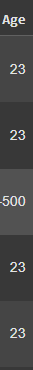

##Visualize and Analysis Data

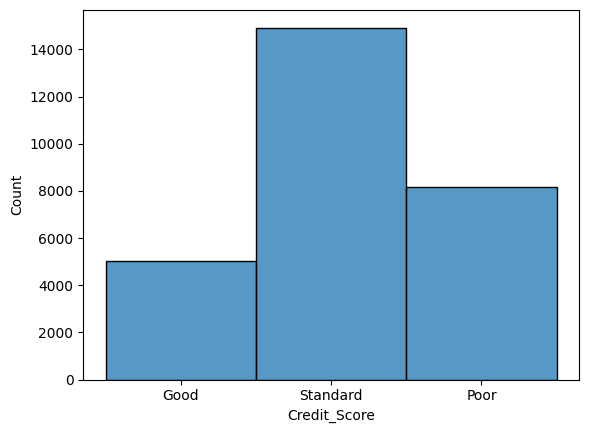

In [25]:
plt.plot(figsize = (5,4))
sns.histplot(df['Credit_Score'])
plt.show()

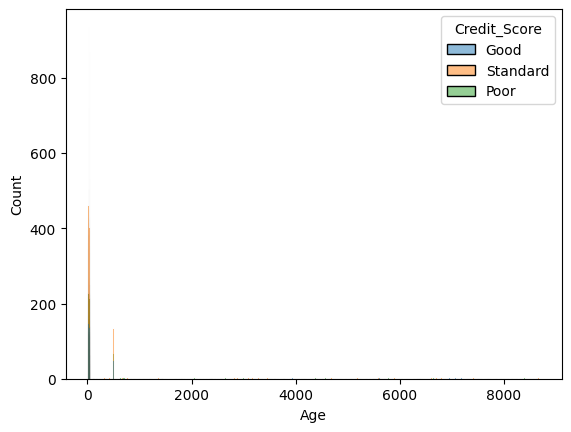

In [26]:
#Relation between Age and Credit score
sns.histplot(data=df, x='Age', hue='Credit_Score')  # Corrected syntax
plt.show()

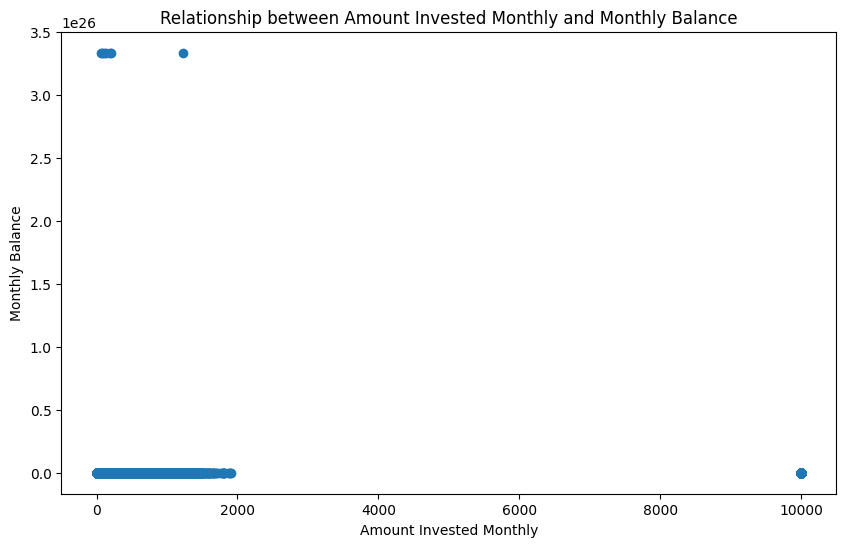

In [27]:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(data=df, x='Amount_invested_monthly', y='Monthly_Balance')
plt.title('Relationship between Amount Invested Monthly and Monthly Balance')
plt.xlabel('Amount Invested Monthly')
plt.ylabel('Monthly Balance')
plt.show()

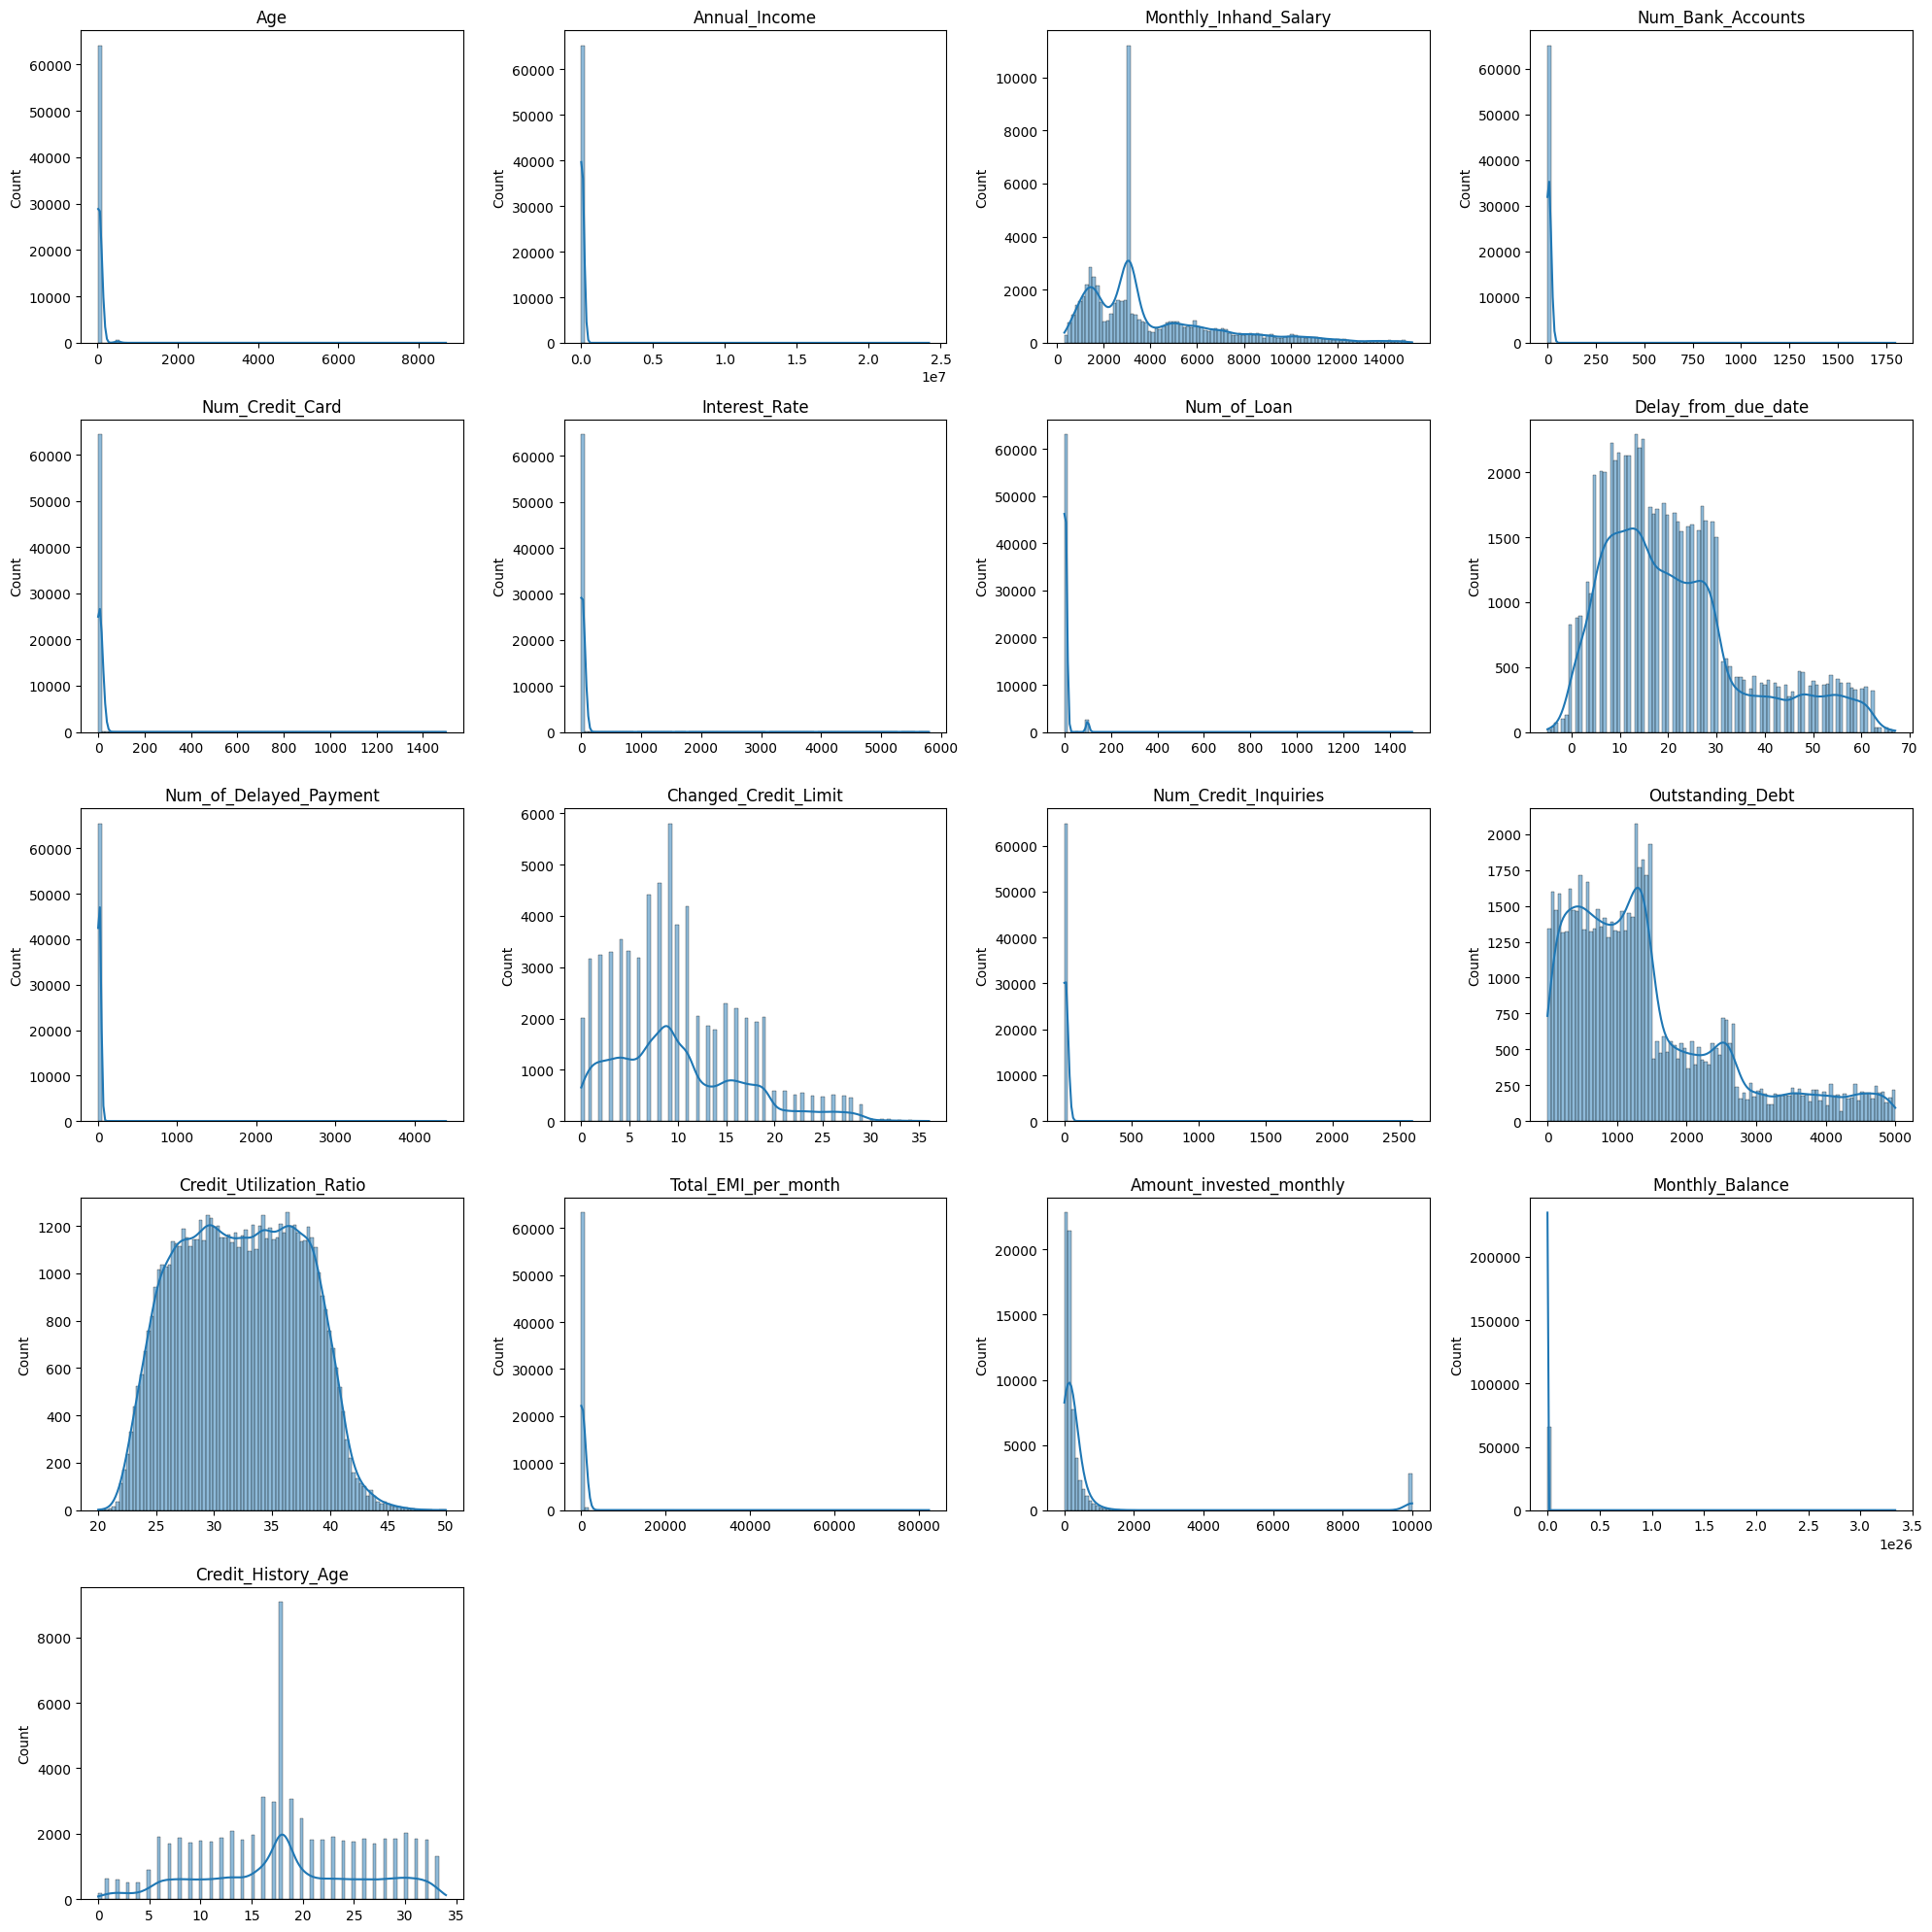

In [28]:
# Counting number of unique element in each column
def plot_histograms(df, columns, rows=2, cols=3):

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axes = axes.flatten() # 2D --> 1D, easier to plot by using iteration

    for i, col in enumerate(columns):
        if i < len(axes):
            sns.histplot(df[col], kde=True, ax=axes[i], bins=100) #kernal density estimate(kde) help to provide smoother line
            axes[i].set_title(col) # title
            axes[i].set_xlabel('')

    # Remove unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_histograms(df, num_cols, rows=5, cols=4)

In [29]:
df = df[df["Credit_History_Age"] != 0] #Extract no Zero-element

In [30]:
df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Spending_Level,Payment_Value
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114,1824.843333,3,...,26.822620,22.0,No,49.574949,80.0,High_spent_Small_value_payments,312.0,Good,High,Small
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114,3096.836667,3,...,31.944960,18.0,No,49.574949,118.0,Low_spent_Large_value_payments,284.0,Good,Low,Large
2,0x1604,CUS_0xd40,March,Aaron Maashoh,500,821-00-0265,Scientist,19114,3096.836667,3,...,28.609352,22.0,No,49.574949,81.0,Low_spent_Medium_value_payments,331.0,Good,Low,Medium
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114,3096.836667,3,...,31.377862,22.0,No,49.574949,199.0,Low_spent_Small_value_payments,223.0,Good,Low,Small
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114,1824.843333,3,...,24.797347,22.0,No,49.574949,41.0,High_spent_Medium_value_payments,341.0,Good,High,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40898,0x1f54c,CUS_0x8a36,November,NaN,38,509-64-1439,Entrepreneur,34102,2742.886667,7,...,23.807748,18.0,Yes,140.119803,136.0,Low_spent_Small_value_payments,165.0,NaN,Low,Small
40899,0x1f54d,CUS_0x8a36,December,Kristeny,38,509-64-1439,Entrepreneur,34102,2742.886667,7,...,38.875719,10.0,NM,140.119803,76.0,Low_spent_Medium_value_payments,337.0,NaN,Low,Medium
40900,0x1f556,CUS_0x54b,September,Evaa,31,468-64-0497,Architect,55209,4303.817500,5,...,33.499413,18.0,NM,231.927811,159.0,High_spent_Small_value_payments,299.0,NaN,High,Small
40901,0x1f557,CUS_0x54b,October,Evaa,31,#F%$D@*&8,Architect,55209,4303.817500,5,...,23.926878,14.0,Yes,231.927811,85.0,High_spent_Medium_value_payments,362.0,NaN,High,Medium


In [31]:
df['Credit_History_Age'].describe()

,Credit_History_Age
count,65753.000000
mean,18.345383
std,7.863401
min,1.000000
25%,13.000000
50%,18.000000
75%,24.000000
max,34.000000


In [32]:
df[df['Credit_History_Age'] < 0].sum()

,0
ID,0
Customer_ID,0
Month,0
Name,0
Age,0
SSN,0
Occupation,0
Annual_Income,0
Monthly_Inhand_Salary,0.0
Num_Bank_Accounts,0


In [33]:
df[num_cols].corr()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_History_Age
Age,1.000000,-0.003229,0.001179,0.004981,0.003089,-0.002259,0.004635,-0.002979,-0.000284,-0.001274,-0.003149,-0.001878,0.001937,0.002609,0.001770,-0.001193,0.003831
Annual_Income,-0.003229,1.000000,0.028530,-0.000364,0.001734,-0.004740,0.001956,-0.006594,-0.001549,-0.001280,-0.001125,-0.002437,0.006789,-0.003264,0.002886,-0.000876,0.001606
Monthly_Inhand_Salary,0.001179,0.028530,1.000000,-0.013709,-0.005281,-0.012831,-0.004152,-0.234568,0.000976,-0.162547,-0.006295,-0.246624,0.151695,0.010035,0.050291,0.001544,0.238801
Num_Bank_Accounts,0.004981,-0.000364,-0.013709,1.000000,-0.000350,-0.001051,0.000361,0.019997,-0.000834,0.014660,0.001379,0.017244,-0.005599,-0.004858,0.001342,-0.001181,-0.014325
Num_Credit_Card,0.003089,0.001734,-0.005281,-0.000350,1.000000,-0.002380,0.001116,0.010431,0.001165,0.003870,-0.003256,0.006519,-0.002655,0.002546,-0.005649,-0.001458,-0.010329
Interest_Rate,-0.002259,-0.004740,-0.012831,-0.001051,-0.002380,1.000000,0.001577,0.016121,0.004166,0.010223,-0.005281,0.011035,-0.004536,0.002958,-0.003361,-0.001330,-0.011587
Num_of_Loan,0.004635,0.001956,-0.004152,0.000361,0.001116,0.001577,1.000000,0.015874,0.006677,0.007536,0.000626,0.018797,0.001975,-0.005054,0.001447,-0.001256,-0.015254
Delay_from_due_date,-0.002979,-0.006594,-0.234568,0.019997,0.010431,0.016121,0.015874,1.000000,0.013557,0.291029,0.005056,0.569940,-0.064783,0.000161,-0.009338,-0.002014,-0.463483
Num_of_Delayed_Payment,-0.000284,-0.001549,0.000976,-0.000834,0.001165,0.004166,0.006677,0.013557,1.000000,0.010530,-0.002004,0.007337,-0.004273,-0.003819,-0.001061,-0.000968,-0.013774
Changed_Credit_Limit,-0.001274,-0.001280,-0.162547,0.014660,0.003870,0.010223,0.007536,0.291029,0.010530,1.000000,0.007493,0.452178,-0.042830,0.001030,-0.012385,-0.007179,-0.398791


##Heatmap

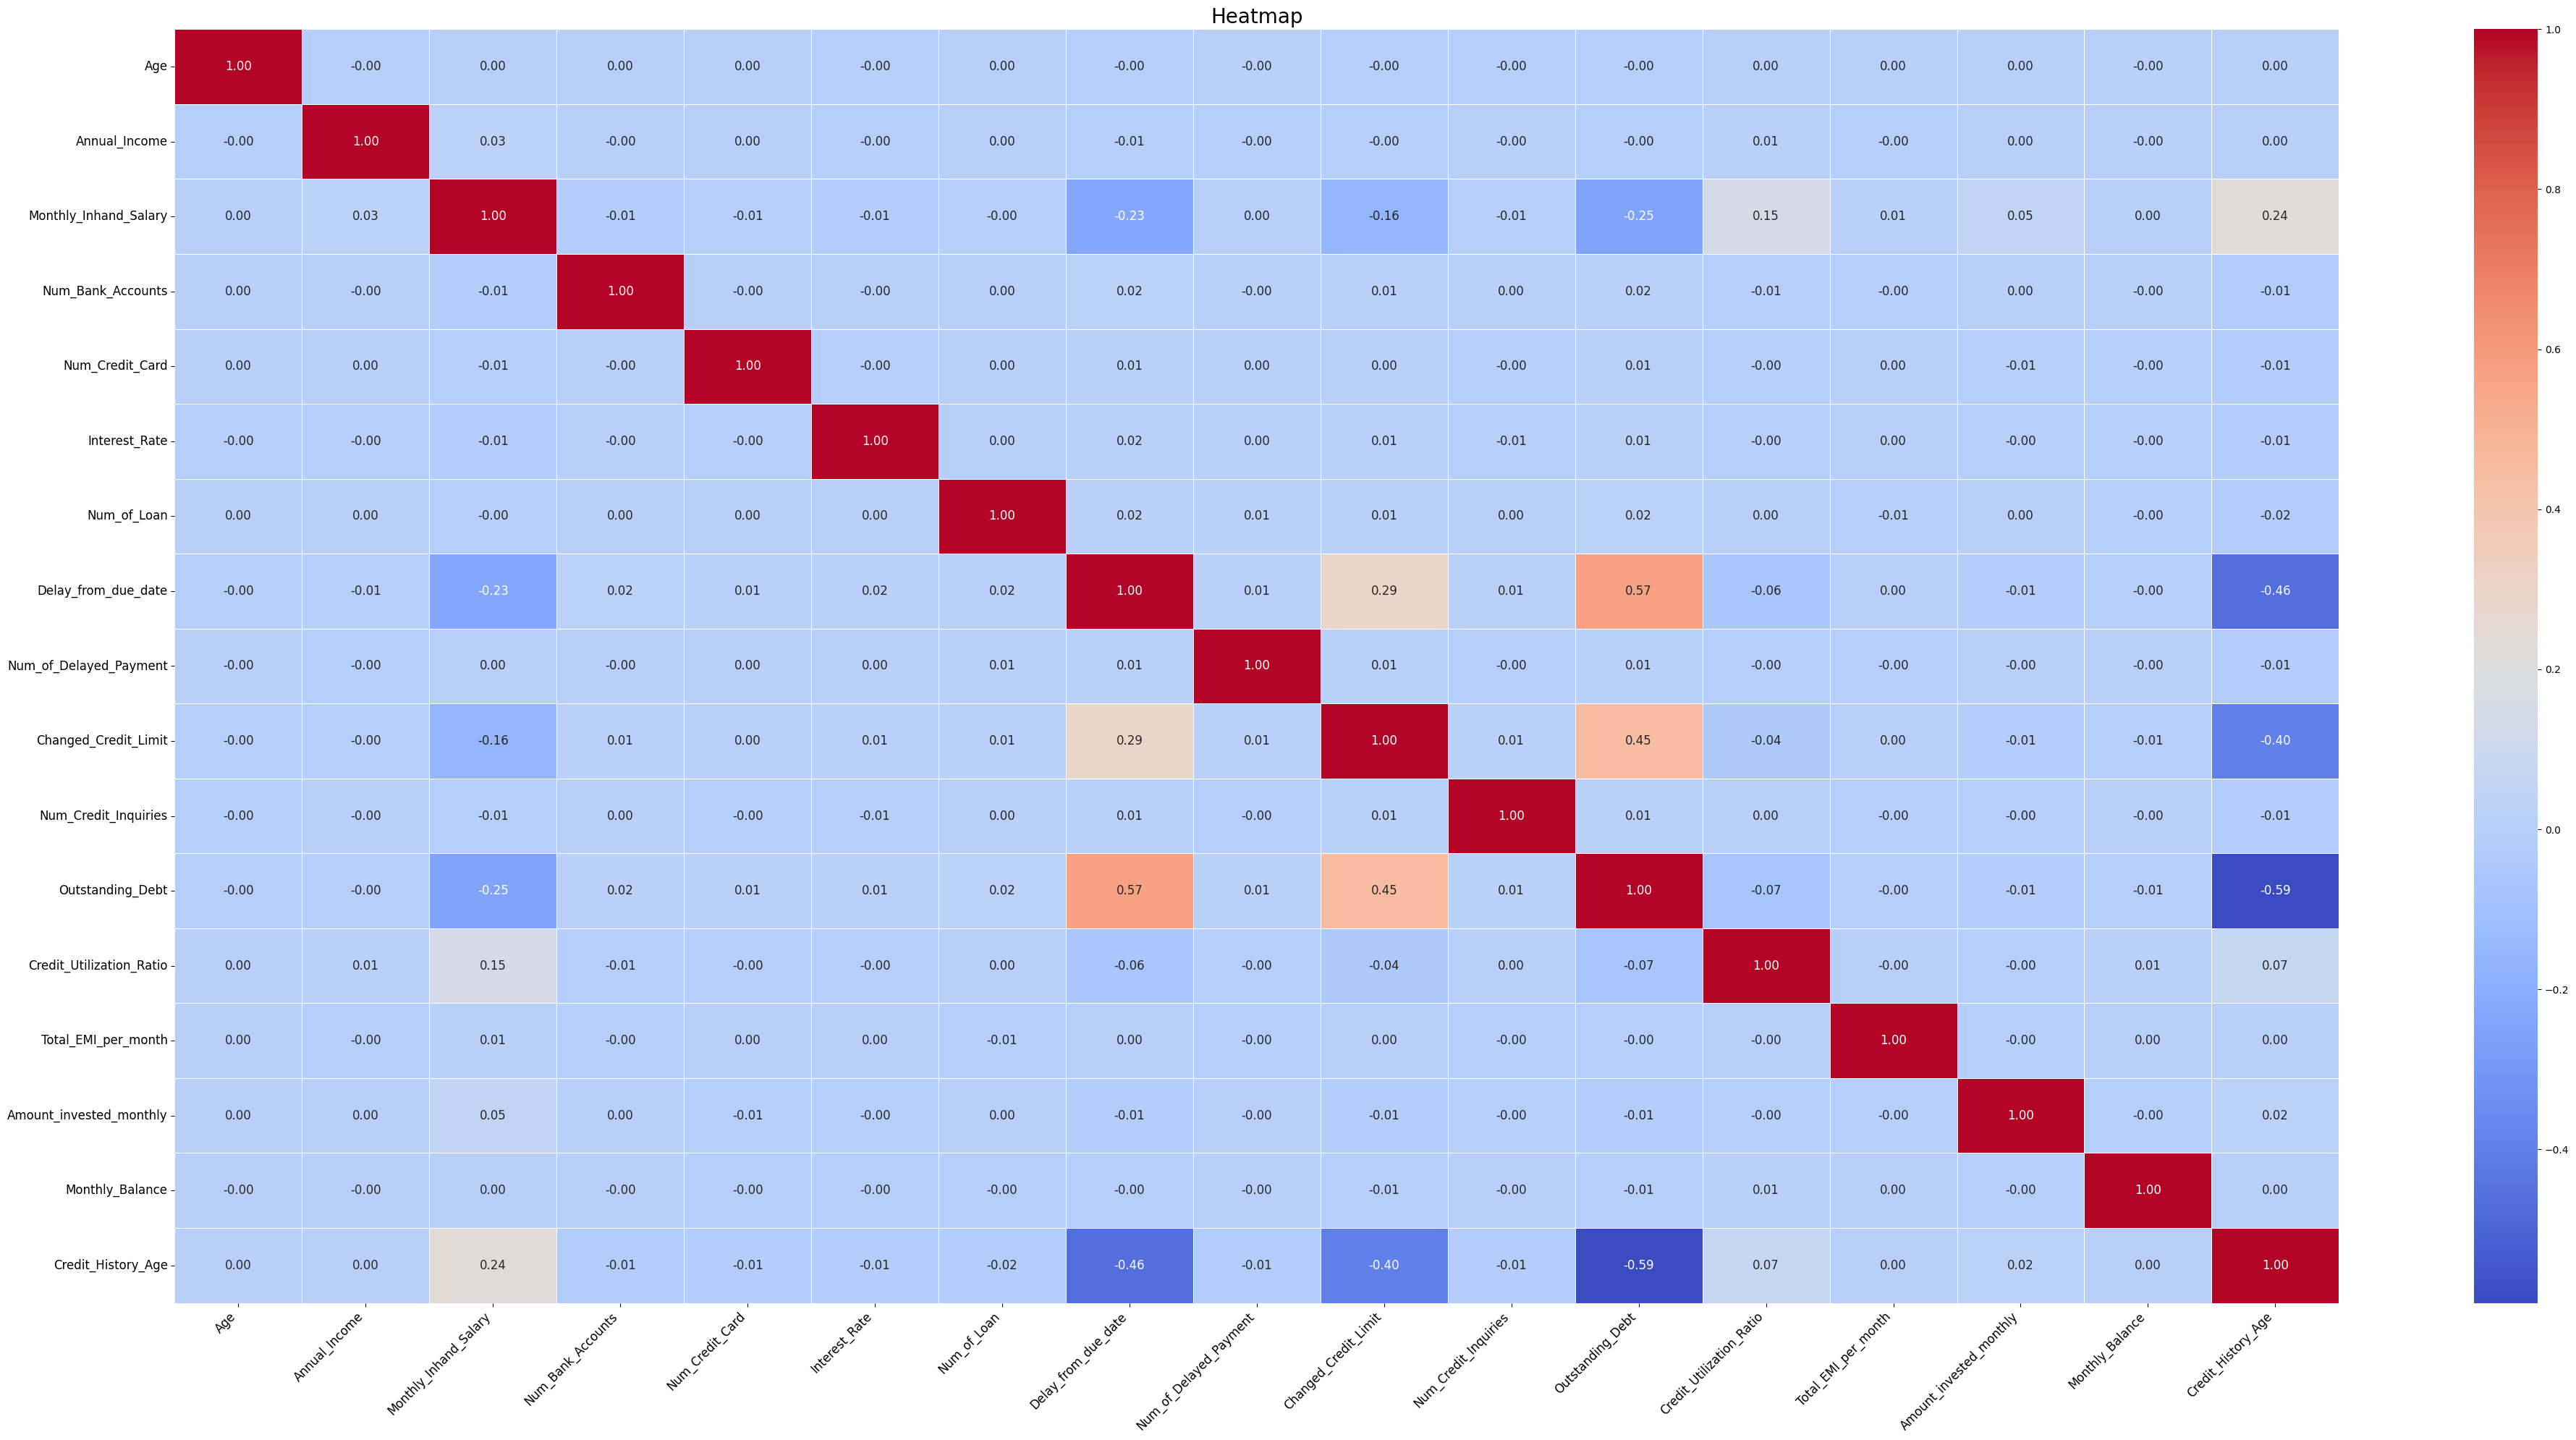

In [34]:
plt.figure(figsize=(40, 20))  # Adjust figure size as needed
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels=num_cols, yticklabels=num_cols,
            linewidths=.5, annot_kws={"size": 12})

plt.title("Heatmap", fontsize=20)  # Increase title font size
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels
plt.yticks(fontsize=12)  # Adjust y-axis label font size
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

##Categorical Column preprocessing

In [35]:
for column in df.columns:
    unique_elements = df[column].unique()
    print(f"Unique elements in column '{column}': {unique_elements}")

Unique elements in column 'ID': ['0x1602' '0x1603' '0x1604' ... '0x1f556' '0x1f557' '0x1f558']
Unique elements in column 'Customer_ID': ['CUS_0xd40' 'CUS_0x21b1' 'CUS_0x2dbc' ... 'CUS_0xc4f' 'CUS_0x8a36'
 'CUS_0x54b']
Unique elements in column 'Month': ['January' 'February' 'March' 'April' 'May' 'July' 'August' 'June'
 'September' 'October' 'November' 'December']
Unique elements in column 'Name': ['Aaron Maashoh' nan 'Rick Rothackerj' ... 'Rhys Jonesb' 'Brettv'
 'Kristeny']
Unique elements in column 'Age': [  23  500   28 ...  425 5679 6278]
Unique elements in column 'SSN': ['821-00-0265' '#F%$D@*&8' '004-07-5839' ... '955-02-8112' '509-64-1439'
 '468-64-0497']
Unique elements in column 'Occupation': ['Scientist' '_______' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer'
 'Lawyer' 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant'
 'Musician' 'Mechanic' 'Writer' 'Architect']
Unique elements in column 'Annual_Income': [ 19114  34847 143162 ...  35462  34102  55209]
Unique eleme

In [36]:
#Showing unique elements from each column
for column in cat_cols:  # Iterate through categorical columns only
    unique_elements = df[column].unique()

    # Format output for better readability
    print(f"\nColumn: {column}")  # Print column name with a newline
    print("-" * 20)  # Print a separator line

    if len(unique_elements) <= 20:  # Limit display if too many unique elements
        print(f"  Unique Elements: {unique_elements}")
    else:
        print(f"  Unique Elements (Count: {len(unique_elements)}): Too many to display.")


Column: Occupation
--------------------
  Unique Elements: ['Scientist' '_______' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer'
 'Lawyer' 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant'
 'Musician' 'Mechanic' 'Writer' 'Architect']

Column: Credit_Mix
--------------------
  Unique Elements: ['_' 'Good' 'Standard' 'Bad' nan]

Column: Spending_Level
--------------------
  Unique Elements: ['High' 'Low' nan]

Column: Payment_Value
--------------------
  Unique Elements: ['Small' 'Large' 'Medium' nan]

Column: Payment_of_Min_Amount
--------------------
  Unique Elements: ['No' 'NM' 'Yes' nan]


In [37]:
#Removing useless value like '_'
def remove_underscore_rows(df, column_name):

    filtered_df = df[~df[column_name].str.contains('_', na=False)]

    removed_rows = len(df) - len(filtered_df)
    print(f"{column_name} column removed {removed_rows} rows.")

    return filtered_df

for col in cat_cols:
    df = remove_underscore_rows(df, col)


Occupation column removed 8699 rows.
Credit_Mix column removed 11482 rows.
Spending_Level column removed 0 rows.
Payment_Value column removed 0 rows.
Payment_of_Min_Amount column removed 0 rows.


In [38]:
for column in cat_cols:  # Iterate through categorical columns only
    unique_count = df[column].nunique()  # Get the count of unique values

    # Format output for better readability
    print(f"\nColumn: {column}")  # Print column name with a newline
    print("-" * 20)  # Print a separator line
    print(f"  Unique Value Count: {unique_count}")  # Print the count of unique values


Column: Occupation
--------------------
  Unique Value Count: 14

Column: Credit_Mix
--------------------
  Unique Value Count: 3

Column: Spending_Level
--------------------
  Unique Value Count: 2

Column: Payment_Value
--------------------
  Unique Value Count: 3

Column: Payment_of_Min_Amount
--------------------
  Unique Value Count: 3


Number of each unique elements from each solumn

In [39]:
for column in cat_cols:  # Iterate through categorical columns only
    unique_counts = df[column].value_counts()

    # Format output for better readability
    print(f"\nColumn: {column}")  # Print column name with a newline
    print("-" * 20)  # Print a separator line

    for element, count in unique_counts.items():  # Iterate through unique elements and counts
        print(f"  {element}: {count}")  # Print element and its count


Column: Occupation
--------------------
  Lawyer: 3486
  Architect: 3417
  Developer: 3344
  Teacher: 3335
  Mechanic: 3335
  Journalist: 3318
  Doctor: 3302
  Entrepreneur: 3249
  Scientist: 3202
  Writer: 3197
  Engineer: 3191
  Accountant: 3095
  Manager: 3068
  Musician: 3033

Column: Credit_Mix
--------------------
  Standard: 20590
  Good: 14063
  Bad: 10918

Column: Spending_Level
--------------------
  Low: 24379
  High: 21191

Column: Payment_Value
--------------------
  Small: 18201
  Medium: 15481
  Large: 11888

Column: Payment_of_Min_Amount
--------------------
  Yes: 23815
  No: 16294
  NM: 5461


In [40]:
#Only need Boolean dtype
replace = {"NM": "No"}
df["Payment_of_Min_Amount"] = df["Payment_of_Min_Amount"].replace(replace)

In [41]:
df["Payment_of_Min_Amount"].value_counts()

,count
Payment_of_Min_Amount,
Yes,23815
No,21755


In [42]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37815 entries, 0 to 40902
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        37815 non-null  object 
 1   Customer_ID               37815 non-null  object 
 2   Month                     37815 non-null  object 
 3   Name                      34010 non-null  object 
 4   Age                       37815 non-null  object 
 5   SSN                       37815 non-null  object 
 6   Occupation                37815 non-null  object 
 7   Annual_Income             37815 non-null  object 
 8   Monthly_Inhand_Salary     32130 non-null  float64
 9   Num_Bank_Accounts         37815 non-null  int64  
 10  Num_Credit_Card           37815 non-null  int64  
 11  Interest_Rate             37815 non-null  int64  
 12  Num_of_Loan               37815 non-null  object 
 13  Type_of_Loan              33544 non-null  object 
 14  Delay_from_

Hypothesis Testing with Chi-Square and F-Tests
This Python code defines a chi_2_test function that conducts hypothesis testing to assess the relationship between categorical and numerical columns in a DataFrame and the target variable 'Credit_Score.'

Function Purpose: The chi_2_test function first prepares a copy of the DataFrame with only training data and selects categorical and numerical columns of interest. It then initializes an empty NumPy array to store test results. The function performs two types of tests: Chi-Square tests for categorical columns and F-tests (ANOVA) for numerical columns to assess their significance in explaining 'Credit_Score' variations.

Hypothesis Testing: The Chi-Square test evaluates the independence between categorical variables and 'Credit_Score,' while the F-tests assess the variance in 'Credit_Score' explained by numerical variables. The results include the test statistic and p-value for each column, helping identify significant factors influencing 'Credit_Score.'

This function provides valuable insights into how different features relate to 'Credit_Score,' aiding in feature selection and understanding the dataset's predictive power in credit scoring analysis or modeling.

In [43]:
#define whole dataframe is use for trainning modole
df['is_train'] = True


A chi-square (χ2) statistic is a test that measures how a model compares to actual observed data. The data used in calculating a chi-square statistic must be random, raw, mutually exclusive, drawn from independent variables, and drawn from a large enough sample. For example, the results of tossing a fair coin meet these criteria.

In [44]:
def chi_2_test(df: pd.DataFrame, cat_cols: list, num_cols: list):
    # Assuming that 'Credit_Score' and 'is_train' columns are in the DataFrame.
    df_copy = df.loc[df["is_train"]].copy()

    summary = np.empty((len(cat_cols) + len(num_cols), 3), dtype="object") #Create an empty numpy array to store the result, 3 value (col_nmae, t_stat, and p-value will be stored)
    y, *_ = df_copy["Credit_Score"].factorize(sort=False) # cat_cole --> num_col to do t-statistic


    #Testing if categorical_vol has relation with numerical_col
    def perform_test(cols, test): #The type of test to perform ("chi2" for categorical variables and "f_classif" for numerical variables).
        if test == "chi2":
            for i, col in enumerate(cols):
                cross = pd.crosstab(index=df_copy[col], columns=[df_copy["Credit_Score"]]) # Applies chi2_contingency() from scipy.stats to compute the Chi-square test statistic and p-value.
                t_stat, pvalue, *_ = chi2_contingency(cross)
                summary[i, :] = [col, t_stat, pvalue] # showing summary

        elif test == "f_classif":
            for i, col in enumerate(cols, start=len(cat_cols)): #operating theory testing
                t_stat, pvalue = f_classif(df_copy[[col]], y.reshape(-1, 1))
                summary[i, :] = [col, t_stat[0], pvalue[0]]


    #Perform the test
    perform_test(cat_cols, test="chi2")


    perform_test(num_cols, test="f_classif")

    # Return results as a DataFrame
    return pd.DataFrame(
        data=summary,
        columns=["column", 't-statistic', "p-value"]
    )

# Assuming cat_cols and num_cols are already defined
chi2_summary = chi_2_test(df, cat_cols, num_cols).sort_values(by="t-statistic", ascending=False)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45572 entries, 1 to 40902
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        45572 non-null  object 
 1   Customer_ID               45572 non-null  object 
 2   Month                     45572 non-null  object 
 3   Name                      40993 non-null  object 
 4   Age                       45572 non-null  int64  
 5   SSN                       45572 non-null  object 
 6   Occupation                45572 non-null  object 
 7   Annual_Income             45572 non-null  int64  
 8   Monthly_Inhand_Salary     45572 non-null  float64
 9   Num_Bank_Accounts         45572 non-null  int64  
 10  Num_Credit_Card           45572 non-null  int64  
 11  Interest_Rate             45572 non-null  int64  
 12  Num_of_Loan               45572 non-null  int64  
 13  Type_of_Loan              40511 non-null  object 
 14  Delay_from_

We can see 5 biggest t-stat values, which represent for big impact those column contact to theory

In [46]:
chi2_summary.style.bar("t-statistic").background_gradient(
    "Blues", subset="t-statistic")

,column,t-statistic,p-value
1,Credit_Mix,7794.516803,0.000000
4,Payment_of_Min_Amount,3261.267609,0.000000
12,Delay_from_due_date,1261.669944,0.000000
16,Outstanding_Debt,1065.135464,0.000000
21,Credit_History_Age,913.995644,0.000000
14,Changed_Credit_Limit,340.516727,0.000000
7,Monthly_Inhand_Salary,254.815921,0.000000
2,Spending_Level,150.406888,0.000000
3,Payment_Value,133.332430,0.000000
0,Occupation,120.254752,0.000000


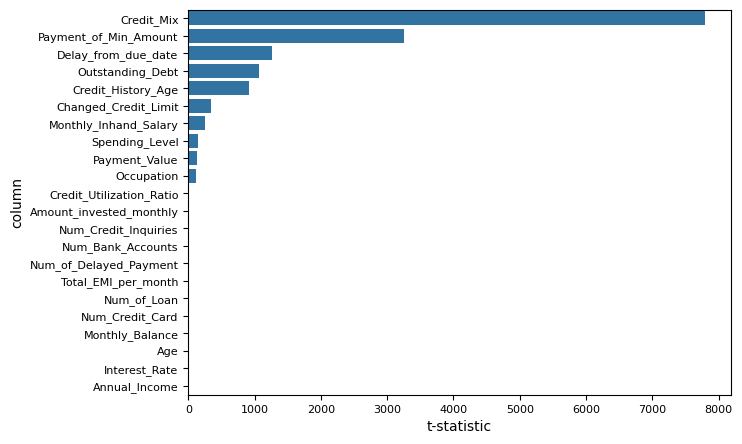

In [47]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(data=chi2_summary, y="column", x="t-statistic", ax=ax)
plt.setp([ax.get_xticklabels(), ax.get_yticklabels()], size=8)
fig.show()

In [48]:
#Remove insignificant column

# Filter out columns with p-value > 0.1
significant_cols = chi2_summary[chi2_summary['p-value'] <= 0.1]['column'].tolist()

# Keep only the significant columns in your original DataFrame (df)
df = df[significant_cols + target_col]

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45572 entries, 1 to 40902
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Credit_Mix                45571 non-null  object 
 1   Payment_of_Min_Amount     45570 non-null  object 
 2   Delay_from_due_date       45572 non-null  int64  
 3   Outstanding_Debt          45572 non-null  float64
 4   Credit_History_Age        45572 non-null  float64
 5   Changed_Credit_Limit      45572 non-null  float64
 6   Monthly_Inhand_Salary     45572 non-null  float64
 7   Spending_Level            45570 non-null  object 
 8   Payment_Value             45570 non-null  object 
 9   Occupation                45572 non-null  object 
 10  Credit_Utilization_Ratio  45572 non-null  float64
 11  Amount_invested_monthly   45572 non-null  float64
 12  Num_Credit_Inquiries      45572 non-null  float64
 13  Num_Bank_Accounts         45572 non-null  int64  
 14  Num_of_Dela

In [50]:
# Already fill the whole column by True
# df[df["is_train"] == False]["Credit_Score"].isna().sum()


In [51]:
# df[df["is_train"] == True]["Credit_Score"].isna().sum()

In [52]:
print(df.columns)

Index(['Credit_Mix', 'Payment_of_Min_Amount', 'Delay_from_due_date',
       'Outstanding_Debt', 'Credit_History_Age', 'Changed_Credit_Limit',
       'Monthly_Inhand_Salary', 'Spending_Level', 'Payment_Value',
       'Occupation', 'Credit_Utilization_Ratio', 'Amount_invested_monthly',
       'Num_Credit_Inquiries', 'Num_Bank_Accounts', 'Num_of_Delayed_Payment',
       'Total_EMI_per_month', 'Credit_Score'],
      dtype='object')


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45572 entries, 1 to 40902
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Credit_Mix                45571 non-null  object 
 1   Payment_of_Min_Amount     45570 non-null  object 
 2   Delay_from_due_date       45572 non-null  int64  
 3   Outstanding_Debt          45572 non-null  float64
 4   Credit_History_Age        45572 non-null  float64
 5   Changed_Credit_Limit      45572 non-null  float64
 6   Monthly_Inhand_Salary     45572 non-null  float64
 7   Spending_Level            45570 non-null  object 
 8   Payment_Value             45570 non-null  object 
 9   Occupation                45572 non-null  object 
 10  Credit_Utilization_Ratio  45572 non-null  float64
 11  Amount_invested_monthly   45572 non-null  float64
 12  Num_Credit_Inquiries      45572 non-null  float64
 13  Num_Bank_Accounts         45572 non-null  int64  
 14  Num_of_Dela

In [54]:
df.to_csv("clean_data.csv", index=False)

In [55]:
train_df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Spending_Level,Payment_Value
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good,High,Small
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good,Low,Large
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good,Low,Medium
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good,Low,Small
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good,High,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30390,0xc810,CUS_0x90cf,July,McCoolw,53_,058-50-1241,Media_Manager,106234.11000000002,8699.842500,4,...,23.595624,27 Years and 3 Months,No,201.113490,325.6671223639741,High_spent_Medium_value_payments,593.2036374964807,Standard,High,Medium
30391,0xc811,CUS_0x90cf,August,McCoolw,53,058-50-1241,Media_Manager,106234.11000000002,8699.842500,4,...,36.009422,NaN,No,201.113490,625.8471560943485,Low_spent_Large_value_payments,313.02360376610636,Standard,Low,Large
30392,0xc816,CUS_0x686c,January,NaN,36,666-90-8248,Developer,10143.89,684.324167,4,...,23.002059,19 Years and 10 Months,Yes,22.886533,50.41183191530408,Low_spent_Small_value_payments,285.134051935071,Standard,Low,Small
30393,0xc817,CUS_0x686c,February,Kiharap,36,666-90-8248,Developer,10143.89,684.324167,4,...,25.142233,NaN,Yes,22.886533,46.36582910605607,Low_spent_Small_value_payments,289.180054744319,Standard,Low,Small


In [56]:
test_df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Spending_Level,Payment_Value
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,809.98,35.030402,22 Years and 9 Months,No,49.574949,236.64268203272135,Low_spent_Small_value_payments,186.26670208571772,Low,Small
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,809.98,33.053114,22 Years and 10 Months,No,49.574949,21.465380264657146,High_spent_Medium_value_payments,361.44400385378196,High,Medium
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,809.98,33.811894,NaN,No,49.574949,148.23393788500925,Low_spent_Medium_value_payments,264.67544623342997,Low,Medium
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,...,809.98,32.430559,23 Years and 0 Months,No,49.574949,39.08251089460281,High_spent_Medium_value_payments,343.82687322383634,High,Medium
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,...,605.03,25.926822,27 Years and 3 Months,No,18.816215,39.684018417945296,High_spent_Large_value_payments,485.2984336755923,High,Large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40898,0x1f54c,CUS_0x8a36,November,NaN,38,509-64-1439,Entrepreneur,34102.64,2742.886667,7,...,4057.35,23.807748,NaN,Yes,140.119803,NaN,Low_spent_Small_value_payments,165.20088172113688,Low,Small
40899,0x1f54d,CUS_0x8a36,December,Kristeny,38,509-64-1439,Entrepreneur,34102.64,2742.886667,7,...,4057.35,38.875719,10 Years and 4 Months,NM,140.119803,76.54325765715589,Low_spent_Medium_value_payments,337.62560602920325,Low,Medium
40900,0x1f556,CUS_0x54b,September,Evaa,31,468-64-0497,Architect,55209.81,4303.817500,5,...,1922.82,33.499413,NaN,NM,231.927811,159.0413097687305,High_spent_Small_value_payments,299.4126290130695,High,Small
40901,0x1f557,CUS_0x54b,October,Evaa,31,#F%$D@*&8,Architect,55209.81,4303.817500,5,...,1922.82,23.926878,14 Years and 8 Months,Yes,231.927811,85.71225287591633,High_spent_Medium_value_payments,362.7416859058836,High,Medium


In [58]:
train_df_cleaned = train_df.dropna()
test_df_cleaned = test_df.dropna()

In [59]:
# Only run if your df has is_trin col before
# train_df = df[df['is_train'] == True].drop(columns=['is_train'])
# test_df = df[df['is_train'] == False].drop(columns=['is_train'])

X = train_df_cleaned.drop(columns=['Credit_Score'])
y = train_df_cleaned['Credit_Score']
X_test = test_df_cleaned

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [60]:
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [61]:
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Class '{class_name}' is encoded as {i}")

Class 'Good' is encoded as 0
Class 'Poor' is encoded as 1
Class 'Standard' is encoded as 2


In [62]:
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
one_hot_cols = ["Occupation", "Payment_of_Min_Amount"]
ordinal_cols = ["Credit_Mix", "Spending_Level", "Payment_Value"]

ordinal_categories = [
    ['Bad', 'Standard', 'Good'],
    ['Low', 'High'],
    ['Small', 'Medium', 'Large']
]

In [63]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_cols),
        ('one_hot_enc', OneHotEncoder(handle_unknown='ignore'), one_hot_cols),
        ('ordinal_enc', OrdinalEncoder(categories=ordinal_categories, handle_unknown="use_encoded_value", unknown_value=-1), ordinal_cols)
    ]
)

In [64]:
X_train

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Spending_Level,Payment_Value
18111,0x801d,CUS_0x9c5b,August,Guptaj,30,604-13-8673,Mechanic,75488.16,6504.680000,7,...,1888.98,29.457638,7 Years and 2 Months,Yes,85.458573,__10000__,Low_spent_Medium_value_payments,238.5008023583524,Low,Medium
89,0x1687,CUS_0xc0ab,February,Soyoungd,33_,342-90-2649,Engineer,88640.24,7266.686667,3,...,950.36,41.036168,25 Years and 6 Months,NM,135.173371,157.174788304235,High_spent_Large_value_payments,674.3205073907143,High,Large
25424,0xaafa,CUS_0xaaf8,January,Lefteris Papadimasx,37,181-79-7057,Teacher,79993.04999999999,6405.087500,7,...,1052.29,31.541390,25 Years and 7 Months,No,188.699875,419.2047150494935,High_spent_Small_value_payments,292.6041598496162,High,Small
25622,0xac20,CUS_0xd3e,July,Peter Laurian,16,920-94-1868,Teacher,15971.125,1129.070905,6,...,335.98,39.170857,12 Years and 7 Months,Yes,158.375856,101.9816688949738,Low_spent_Small_value_payments,267.79136208934483,Low,Small
10208,0x51d2,CUS_0x8f25,January,Luciana Lopezp,3285,616-67-8262,Teacher,98759.91,8524.992500,5,...,1371.02,29.751947,26 Years and 2 Months,No,98.721279,213.56931443039258,High_spent_Small_value_payments,800.2086568259532,High,Small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22620,0x9a8a,CUS_0xc0d9,May,Lukew,34_,762-52-2841,Accountant,17078.485,1256.207083,3,...,1048.53,30.494154,24 Years and 0 Months,No,22.181582,128.96956200544264,Low_spent_Small_value_payments,264.4695643807905,Low,Small
26501,0xb147,CUS_0x7df6,June,Valetkevitchr,39,#F%$D@*&8,Scientist,14085.15,1330.762500,3,...,298.5,34.994774,16 Years and 6 Months,No,31.309071,145.24848413480484,Low_spent_Small_value_payments,246.51869493908995,Low,Small
2677,0x25af,CUS_0x49dd,June,Masond,14,966-28-7046,Engineer,15544.47,1030.372500,8,...,2909.71,34.429752,1 Years and 8 Months,Yes,35.256798,72.24402102483664,Low_spent_Small_value_payments,285.53643067282644,Low,Small
14775,0x6c91,CUS_0xb99c,August,Donny Kwokx,32_,896-23-4660,Writer,97338.21,8220.517500,8,...,1052.21,27.654476,29 Years and 0 Months,No,36271.000000,196.32734595752444,Low_spent_Large_value_payments,591.7412626309025,Low,Large


In [65]:
test_df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Spending_Level,Payment_Value
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,809.98,35.030402,22 Years and 9 Months,No,49.574949,236.64268203272135,Low_spent_Small_value_payments,186.26670208571772,Low,Small
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,809.98,33.053114,22 Years and 10 Months,No,49.574949,21.465380264657146,High_spent_Medium_value_payments,361.44400385378196,High,Medium
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,809.98,33.811894,NaN,No,49.574949,148.23393788500925,Low_spent_Medium_value_payments,264.67544623342997,Low,Medium
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,...,809.98,32.430559,23 Years and 0 Months,No,49.574949,39.08251089460281,High_spent_Medium_value_payments,343.82687322383634,High,Medium
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,...,605.03,25.926822,27 Years and 3 Months,No,18.816215,39.684018417945296,High_spent_Large_value_payments,485.2984336755923,High,Large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40898,0x1f54c,CUS_0x8a36,November,NaN,38,509-64-1439,Entrepreneur,34102.64,2742.886667,7,...,4057.35,23.807748,NaN,Yes,140.119803,NaN,Low_spent_Small_value_payments,165.20088172113688,Low,Small
40899,0x1f54d,CUS_0x8a36,December,Kristeny,38,509-64-1439,Entrepreneur,34102.64,2742.886667,7,...,4057.35,38.875719,10 Years and 4 Months,NM,140.119803,76.54325765715589,Low_spent_Medium_value_payments,337.62560602920325,Low,Medium
40900,0x1f556,CUS_0x54b,September,Evaa,31,468-64-0497,Architect,55209.81,4303.817500,5,...,1922.82,33.499413,NaN,NM,231.927811,159.0413097687305,High_spent_Small_value_payments,299.4126290130695,High,Small
40901,0x1f557,CUS_0x54b,October,Evaa,31,#F%$D@*&8,Architect,55209.81,4303.817500,5,...,1922.82,23.926878,14 Years and 8 Months,Yes,231.927811,85.71225287591633,High_spent_Medium_value_payments,362.7416859058836,High,Medium


In [66]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_train = pipeline.fit_transform(X_train)
X_val = pipeline.transform(X_val)
X_test = pipeline.transform(X_test)

#SMOTE

In [ ]:
#Checking ANN

In [68]:
from collections import Counter
print("Before:", Counter(y_train_encoded))
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)
print("After:", Counter(y_train_resampled))

Before: Counter({np.int64(2): 6252, np.int64(1): 3664, np.int64(0): 1961})
After: Counter({np.int64(1): 6252, np.int64(0): 6252, np.int64(2): 6252})


# ANN

In [69]:
from tensorflow.keras.layers import BatchNormalization

In [70]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred_probabilities = model.predict(X_train)
    y_train_pred = y_train_pred_probabilities.argmax(axis=1)
    y_pred_probabilities = model.predict(X_test)
    y_pred = y_pred_probabilities.argmax(axis=1)

    print("Test Set:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    print("\nTrain Set:")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [71]:
model = Sequential([
    Dense(512, activation='relu'),
    BatchNormalization(),


    Dense(512, activation='relu'),
    BatchNormalization(),

    Dense(256, activation='relu'),
    BatchNormalization(),


    Dense(256, activation='relu'),
    BatchNormalization(),


    Dense(128, activation='relu'),
    BatchNormalization(),


    Dense(64, activation='relu'),
    BatchNormalization(),


    Dense(64, activation='relu'),
    BatchNormalization(),


    Dense(32, activation='relu'),
    BatchNormalization(),

    Dense(3, activation='softmax')
])


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=35,
                               restore_best_weights=True)


history = model.fit(x=X_train_resampled,
                    y=y_train_resampled,
                    validation_data=(X_val, y_val_encoded),
                    validation_split=0.2,
                    batch_size=512,
                    epochs=600,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/600
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.5604 - loss: 1.0431 - val_accuracy: 0.5131 - val_loss: 1.1330
Epoch 2/600
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6705 - loss: 0.7630 - val_accuracy: 0.5168 - val_loss: 1.0160
Epoch 3/600
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6898 - loss: 0.7215 - val_accuracy: 0.5212 - val_loss: 0.9786
Epoch 4/600
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6950 - loss: 0.7045 - val_accuracy: 0.5269 - val_loss: 1.0290
Epoch 5/600
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7129 - loss: 0.6673 - val_accuracy: 0.5360 - val_loss: 0.9197
Epoch 6/600
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.7159 - loss: 0.6465 - val_accuracy: 0.5229 - val_loss: 0.9930
Epoch 7/600
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7333 - loss: 0.6152 - val_accuracy: 0.5320 - val_loss: 1.1091
Epoch 8/600
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7433 - loss: 0.5938 - val_accuracy: 0

In [72]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │          15,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 1,584,011 (6.04 MB)

 Trainable params: 526,787 (2.01 MB)

 Non-trainable params: 3,648 (14.25 KB)

 Optimizer params: 1,053,576 (4.02 MB)

In [73]:
eval_metric(model, X_train_resampled,y_train_resampled, X_val, y_val_encoded)

587/587 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test Set:
[[ 304   31  156]
 [  57  571  288]
 [ 198  316 1049]]
              precision    recall  f1-score   support

           0       0.54      0.62      0.58       491
           1       0.62      0.62      0.62       916
           2       0.70      0.67      0.69      1563

    accuracy                           0.65      2970
   macro avg       0.62      0.64      0.63      2970
weighted avg       0.65      0.65      0.65      2970


Train Set:
[[5981  113  158]
 [ 133 5909  210]
 [ 229  326 5697]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6252
           1       0.93      0.95      0.94      6252
           2       0.94      0.91      0.93      6252

    accuracy                           0.94     18756
   macro avg       0.94      0.94      0.94     18756
weighted avg       0.94      0.94      0.94     18756



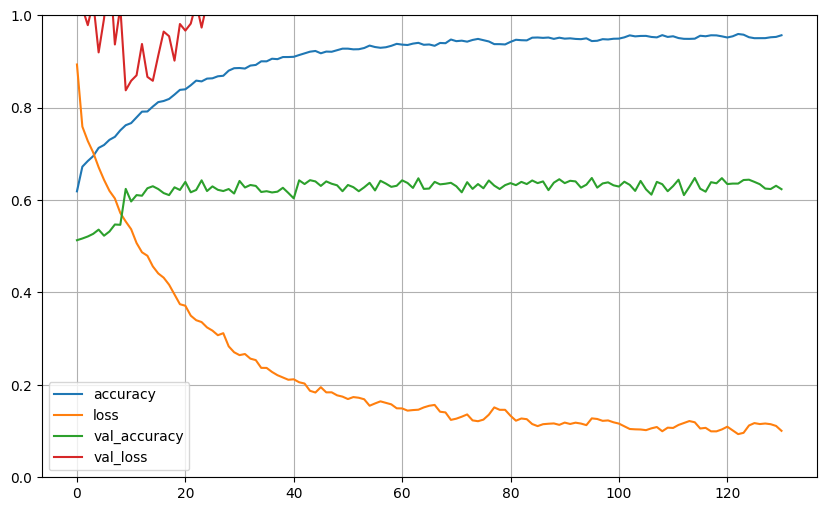

In [74]:
pd.DataFrame(history.history).plot(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()